In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.utils import shuffle
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    fbeta_score,
    cohen_kappa_score,
    roc_curve,
    auc,
    precision_recall_curve
)
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline

In [9]:
features_wide = pd.read_csv("C:/Users/u840716/Anna Thesis/Code Files -/Models/ML_models/summary_features_wide_final_2.csv")

### Evaluation function

In [3]:
def evaluate_model(model, X_test, y_test, model_name="Model", save_fig=False):
    # Predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Basic Metrics
    cm = confusion_matrix(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    kappa = cohen_kappa_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"Evaluation for {model_name}")
    print("-" * 40)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"F2 Score: {f2:.4f}")
    print(f"Cohen’s Kappa: {kappa:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("-" * 40)

    # Plotting
    plt.figure(figsize=(18, 5))

    # Confusion Matrix
    plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(ticks=[0.5, 1.5], labels=["Control (0)", "VT (1)"])
    plt.yticks(ticks=[0.5, 1.5], labels=["Control (0)", "VT (1)"], rotation=0)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.subplot(1, 3, 2)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    plt.subplot(1, 3, 3)
    plt.plot(recall, precision, label=f"AUC = {pr_auc:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()

    plt.tight_layout()
    if save_fig:
        plt.savefig(f"{model_name.replace(' ', '_')}_evaluation.pdf", format="pdf", bbox_inches="tight")
    plt.show()

Split by vt and control for imputation

In [4]:
# Split features and labels
X = features_wide.drop(columns=["PatID", "Patient_Type"])
y = features_wide["Patient_Type"]

# 1. Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 2. Split by class
X_vt_train = X_train[y_train == 1]
X_control_train = X_train[y_train == 0]
X_vt_test = X_test[y_test == 1]
X_control_test = X_test[y_test == 0]

In [16]:
def impute_and_evaluate_rf(imputer_vt, imputer_control, name):
    X_vt_train_imputed = pd.DataFrame(imputer_vt.fit_transform(X_vt_train), columns=X.columns)
    X_control_train_imputed = pd.DataFrame(imputer_control.fit_transform(X_control_train), columns=X.columns)

    X_vt_test_imputed = pd.DataFrame(imputer_vt.transform(X_vt_test), columns=X.columns)
    X_control_test_imputed = pd.DataFrame(imputer_control.transform(X_control_test), columns=X.columns)

    X_train_final = pd.concat([X_vt_train_imputed, X_control_train_imputed])
    y_train_final = pd.concat([y_train[y_train == 1], y_train[y_train == 0]])

    X_test_final = pd.concat([X_vt_test_imputed, X_control_test_imputed])
    y_test_final = pd.concat([y_test[y_test == 1], y_test[y_test == 0]])


    model = RandomForestClassifier(random_state=42, n_estimators=100)
    model.fit(X_train_final, y_train_final)

    evaluate_model(model, X_test_final, y_test_final, model_name=f"Random Forest - {name}")

Compare the different imputation methods

Evaluation for Random Forest - Mean Imputation (per class)
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       397
           1       1.00      0.38      0.55        29

    accuracy                           0.96       426
   macro avg       0.98      0.69      0.76       426
weighted avg       0.96      0.96      0.95       426

F2 Score: 0.4331
Cohen’s Kappa: 0.5325
ROC AUC Score: 0.9864
----------------------------------------


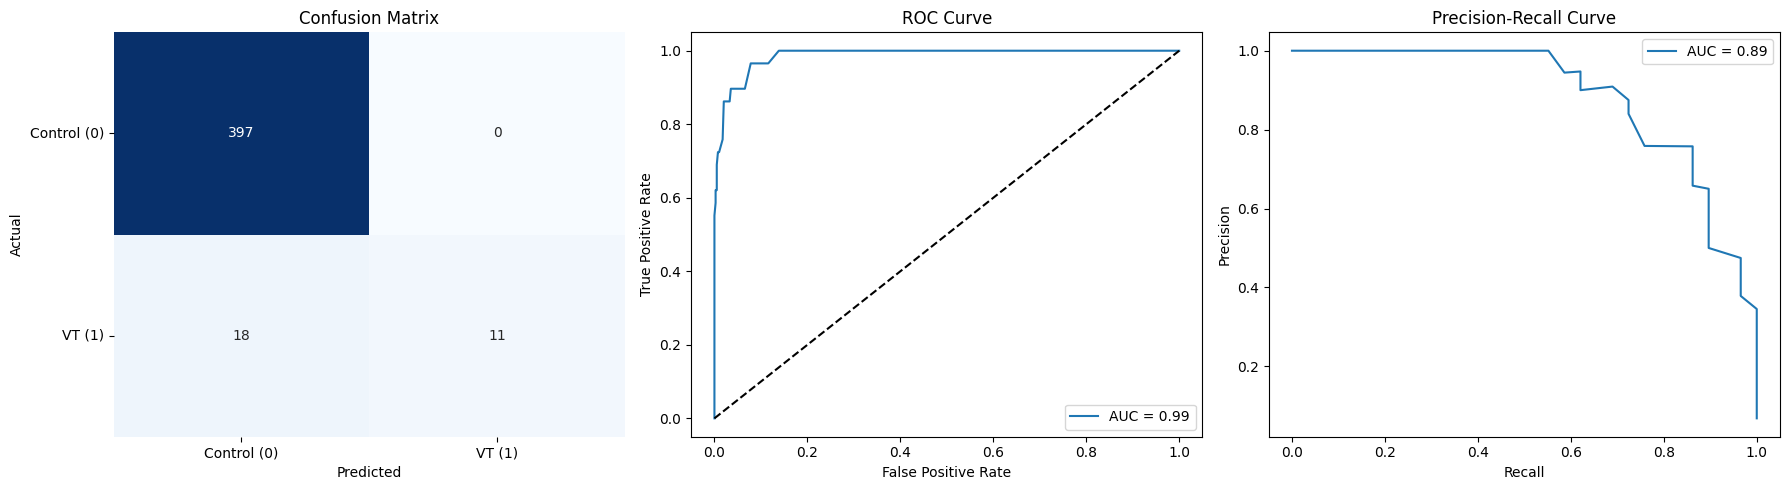

Evaluation for Random Forest - Median Imputation (per class)
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       397
           1       1.00      0.38      0.55        29

    accuracy                           0.96       426
   macro avg       0.98      0.69      0.76       426
weighted avg       0.96      0.96      0.95       426

F2 Score: 0.4331
Cohen’s Kappa: 0.5325
ROC AUC Score: 0.9881
----------------------------------------


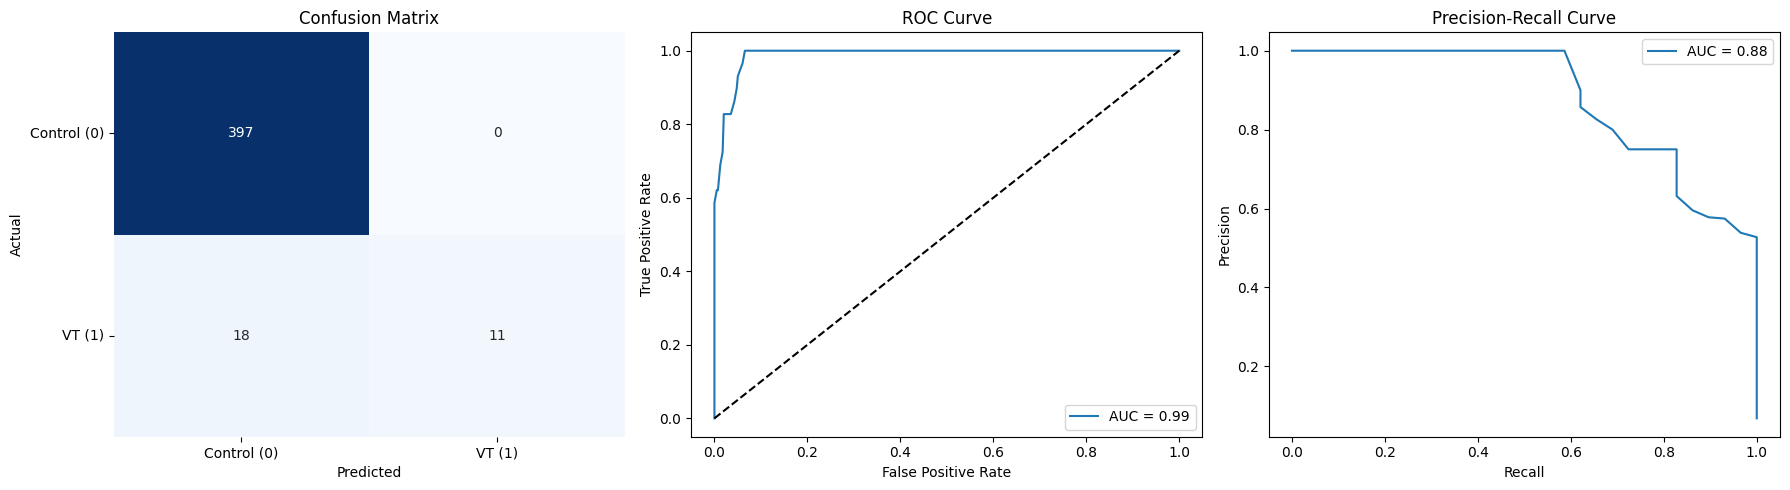

Evaluation for Random Forest - KNN Imputation (per class)
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97       397
           1       1.00      0.03      0.07        29

    accuracy                           0.93       426
   macro avg       0.97      0.52      0.52       426
weighted avg       0.94      0.93      0.90       426

F2 Score: 0.0427
Cohen’s Kappa: 0.0624
ROC AUC Score: 0.8668
----------------------------------------


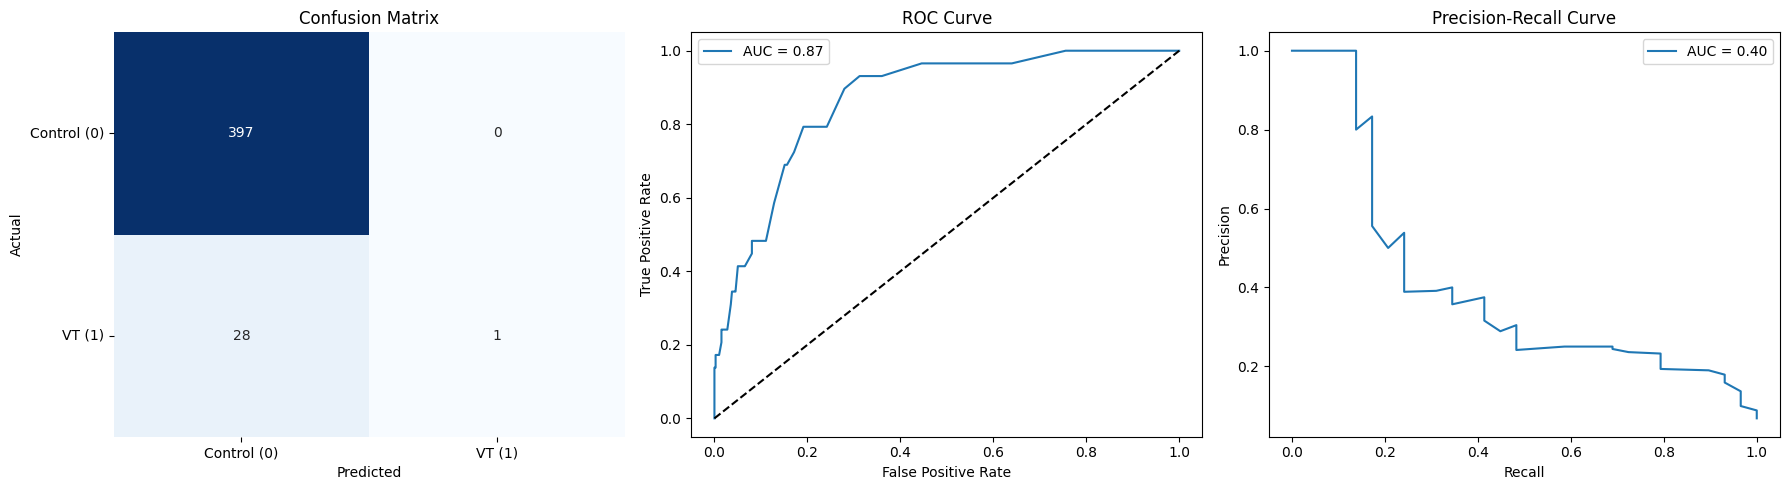

In [17]:
mean_vt = SimpleImputer(strategy='mean')
mean_control = SimpleImputer(strategy='mean')
impute_and_evaluate_rf(mean_vt, mean_control, "Mean Imputation (per class)")

median_vt = SimpleImputer(strategy='median')
median_control = SimpleImputer(strategy='median')
impute_and_evaluate_rf(median_vt, median_control, "Median Imputation (per class)")

knn_vt = KNNImputer(n_neighbors=5)
knn_control = KNNImputer(n_neighbors=5)
impute_and_evaluate_rf(knn_vt, knn_control, "KNN Imputation (per class)")

median performs slightly better than mean

In [10]:
# Impute Train Set
X_vt_train_imputed = pd.DataFrame(median_vt.fit_transform(X_vt_train), columns=X.columns)
X_control_train_imputed = pd.DataFrame(median_control.fit_transform(X_control_train), columns=X.columns)
X_train_median = pd.concat([X_vt_train_imputed, X_control_train_imputed])
y_train_median = pd.concat([y_train[y_train == 1], y_train[y_train == 0]])

# Impute Test Set using train imputers
X_vt_test_imputed = pd.DataFrame(median_vt.transform(X_vt_test), columns=X.columns)
X_control_test_imputed = pd.DataFrame(median_control.transform(X_control_test), columns=X.columns)
X_test_median = pd.concat([X_vt_test_imputed, X_control_test_imputed])
y_test_median = pd.concat([y_test[y_test == 1], y_test[y_test == 0]])

# Shuffle training data
X_train_median, y_train_median = shuffle(X_train_median, y_train_median, random_state=42)

Oversampling

Evaluation for RF - Median Imputation + ADASYN
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       397
           1       0.68      0.45      0.54        29

    accuracy                           0.95       426
   macro avg       0.82      0.72      0.76       426
weighted avg       0.94      0.95      0.94       426

F2 Score: 0.4815
Cohen’s Kappa: 0.5156
ROC AUC Score: 0.9803
----------------------------------------


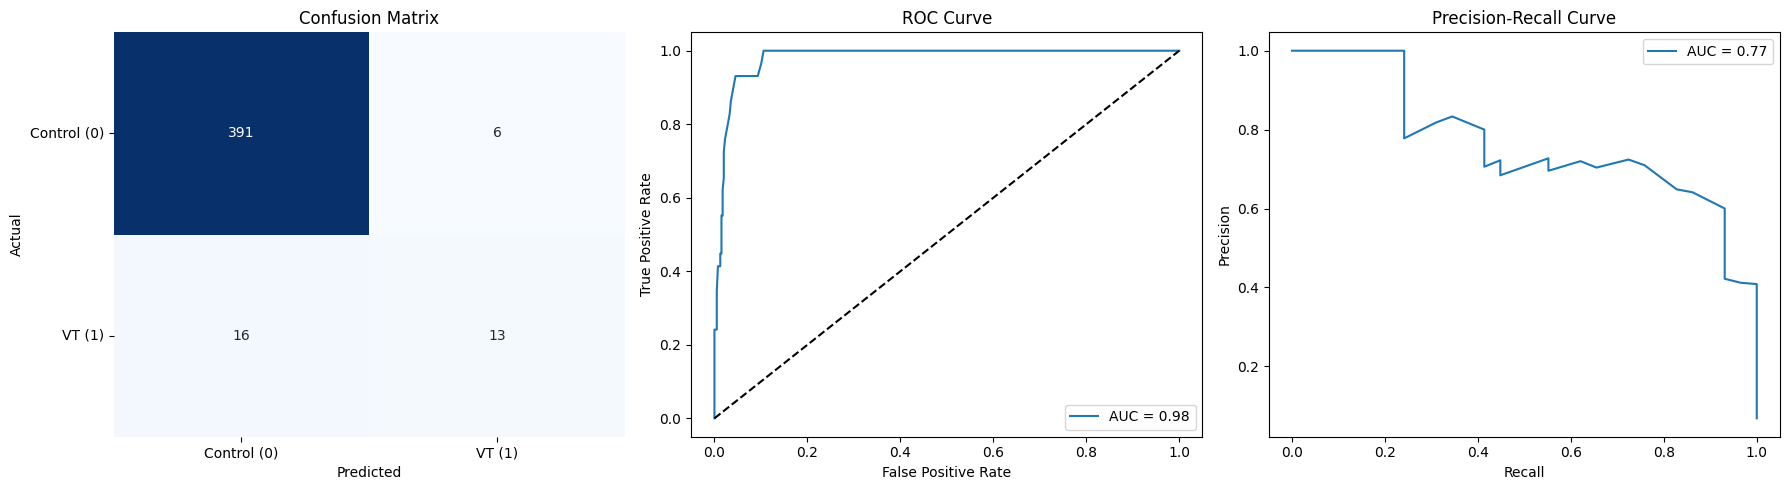

Evaluation for RF - Median Imputation + SMOTE
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       397
           1       0.69      0.31      0.43        29

    accuracy                           0.94       426
   macro avg       0.82      0.65      0.70       426
weighted avg       0.93      0.94      0.93       426

F2 Score: 0.3488
Cohen’s Kappa: 0.4034
ROC AUC Score: 0.9798
----------------------------------------


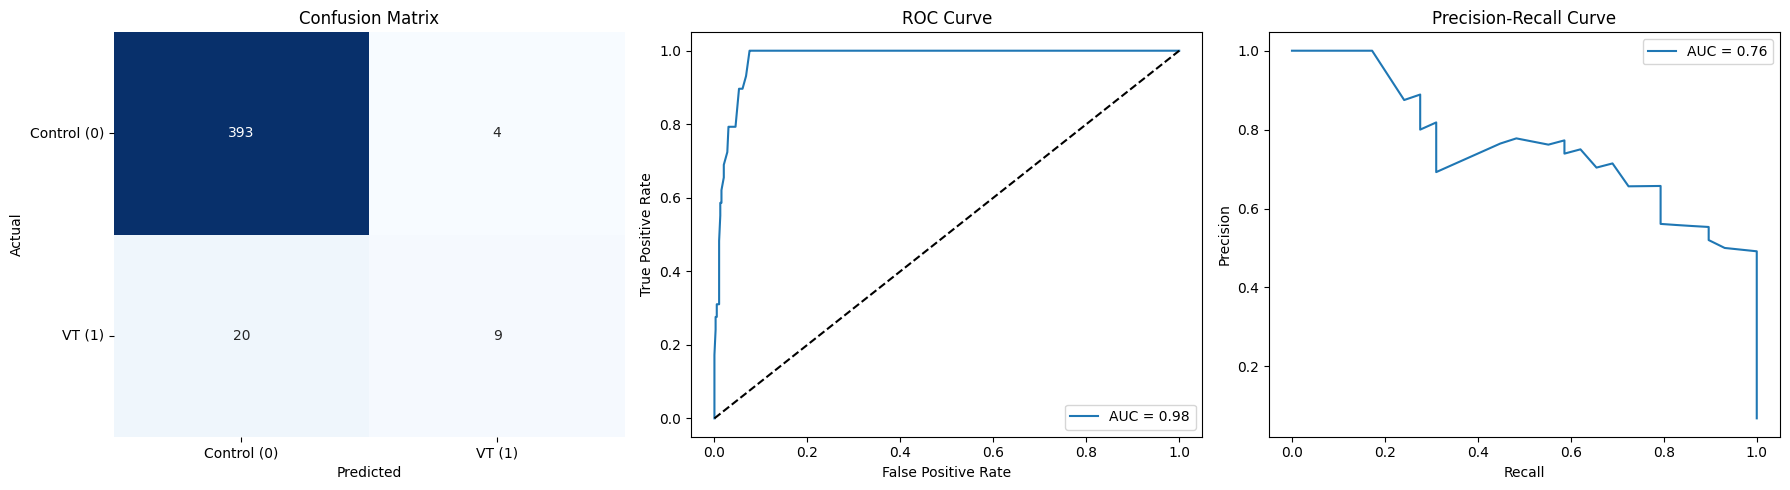

In [12]:
# Define oversamplers
adasyn = ADASYN(random_state=42)
smote = SMOTE(random_state=42)

# Apply ADASYN
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_median, y_train_median)
model_adasyn = RandomForestClassifier(random_state=42, n_estimators=100)
model_adasyn.fit(X_train_adasyn, y_train_adasyn)
evaluate_model(model_adasyn, X_test_median, y_test_median, model_name="RF - Median Imputation + ADASYN", save_fig=True)

# Apply SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train_median, y_train_median)
model_smote = RandomForestClassifier(random_state=42, n_estimators=100)
model_smote.fit(X_train_smote, y_train_smote)
evaluate_model(model_smote, X_test_median, y_test_median, model_name="RF - Median Imputation + SMOTE", save_fig=True)

median with adasyn imputation performs best

# Hyperparameter tuning

First attempt, worse

In [ ]:
# Define parameter grid
param_dist_rf = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

# use F2-score 
from sklearn.metrics import make_scorer, fbeta_score
f2_scorer = make_scorer(fbeta_score, beta=2)

search_rf = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist_rf,
    n_iter=40,    
    scoring=f2_scorer,
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42
)

search_rf.fit(X_train_adasyn, y_train_adasyn)  

Fitting 5 folds for each of 40 candidates, totalling 200 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400]},
                   random_state=42,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
                   verbose=2)

Best Random Forest Parameters:
{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': False}
Evaluation for Tuned Random Forest + Mean Imputation + SMOTE
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       397
           1       0.78      0.24      0.37        29

    accuracy                           0.94       426
   macro avg       0.86      0.62      0.67       426
weighted avg       0.94      0.94      0.93       426

F2 Score: 0.2800
Cohen’s Kappa: 0.3474
ROC AUC Score: 0.9796
----------------------------------------


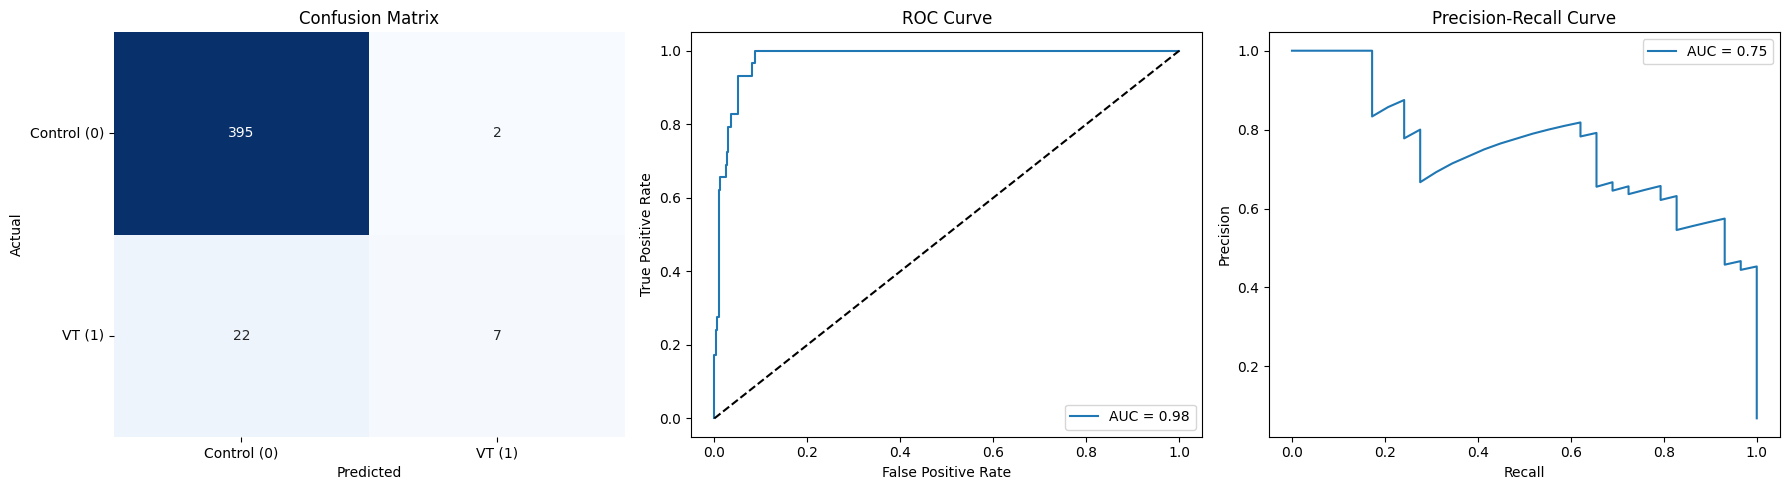

In [ ]:
best_rf = search_rf.best_estimator_
print("Best Random Forest Parameters:")
print(search_rf.best_params_)


evaluate_model(best_rf, X_test_median, y_test_median, model_name="Tuned Random Forest + Mean Imputation + SMOTE")

second attempt, better than first attempt but still worse than default

Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\u840716\Anna Thesis\venv\Lib\site-packages\sklearn\ensemble\_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


Best parameters: {'rf__n_estimators': 800, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 1, 'rf__max_features': 'log2', 'rf__max_depth': 50, 'rf__class_weight': 'balanced_subsample'}
Best CV AUC   : 1.0


c:\Users\u840716\Anna Thesis\venv\Lib\site-packages\sklearn\ensemble\_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
c:\Users\u840716\Anna Thesis\venv\Lib\site-packages\sklearn\ensemble\_forest.py:466: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


Optimal threshold for F2: 0.31, F2 = 0.819
Evaluation for Random Forest Tuned
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       397
           1       0.80      0.28      0.41        29

    accuracy                           0.95       426
   macro avg       0.87      0.64      0.69       426
weighted avg       0.94      0.95      0.93       426

F2 Score: 0.3175
Cohen’s Kappa: 0.3889
ROC AUC Score: 0.9798
----------------------------------------


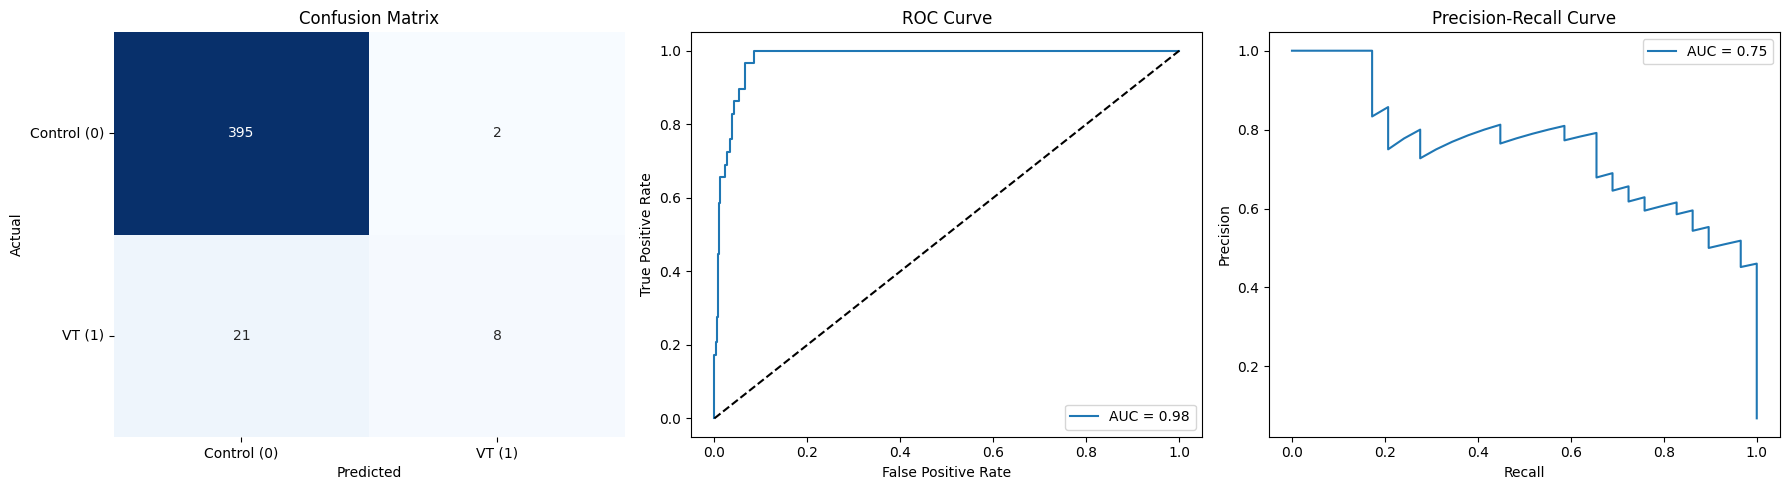

In [ ]:
# Build imbalanced‐learn Pipeline
pipe = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        warm_start=True        
    ))
])

# search space 
param_dist = {
    'rf__n_estimators':    [200, 400, 600, 800],
    'rf__max_depth':       [None, 10, 20, 30, 50],
    'rf__min_samples_split':[2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features':    ['sqrt', 'log2'],
    'rf__class_weight':    [None, 'balanced', 'balanced_subsample']
}

# Stratified CV and RandomizedSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=50,             # more trials for a better search
    scoring='roc_auc',     # optimize AUC first
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Run search on original training data (no oversampling)
search.fit(X_train_adasyn, y_train_adasyn)

print("Best parameters:", search.best_params_)
print("Best CV AUC   :", search.best_score_)

# retrieve best pipeline and re-fit on full training set
best_rf = search.best_estimator_
best_rf.fit(X_train_adasyn, y_train_adasyn)

# Evaluate on test set with threshold tuning for F2
y_prob = best_rf.predict_proba(X_test_median)[:,1]

# find best threshold by F2

ths = np.linspace(0.01,0.99,99)
f2s = [fbeta_score(y_test_median, (y_prob>t).astype(int), beta=2) for t in ths]
best_t = ths[np.argmax(f2s)]
print(f"Optimal threshold for F2: {best_t:.2f}, F2 = {max(f2s):.3f}")

y_pred = (y_prob > best_t).astype(int)


evaluate_model(best_rf, X_test_median, y_test_median, model_name="Random Forest Tuned", save_fig=True)